# Plotting GeoJSON with Python

After I have became more or less familiar with working with GeoJSON in R, I wanted to do the same in Python. The plotting part seemed very obvious: matplotlib, but the GeoJSON part was the real task.

The first promising sample was http://gis.stackexchange.com/a/93201 but it is too low-level solution for my taste and needs. It reads the GeoJSON as a JSON extracts the coordinates and passes for plotting... The sample uses a `Polygon` type, but usually I have MultiPolygon so I had to add other layer of complexity, but I really wanted a one-line solution.

At first I tried to avoid the Plotly and the Leaflet type solutions, those two are great and I might use them eventually, but currently I only wanted the simpliest solution available out there. Then I read about `geopandas` here: https://asecuritysite.com/bigdata/geo02 I like `pandas` and I almost knew that I found what I was looking for.

## Plot a GeoJSON file

The GeoJSON I work with represents the districts of [`Budapest`](https://en.wikipedia.org/wiki/Budapest) taken from [`OpenStreetMap`](http://www.openstreetmap.org/).
It is really simple: just read the GeoJSON into a GeoPandas GeoDataFrame then plot it!

It seems that ` plt.savefig("output.png", format='PNG')` has to be in the same notebook cell as the `df.plot()`.

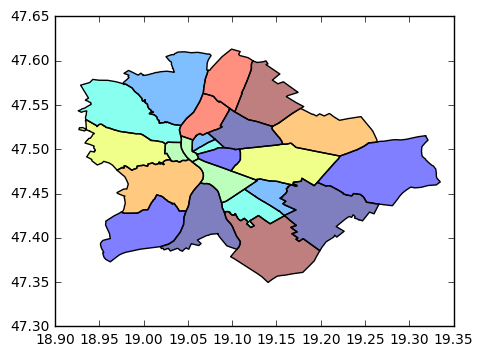

In [25]:
%matplotlib inline
import geopandas as gpd
import matplotlib.pyplot as plt

df = gpd.read_file("input/bp_districts.geojson.json")
plot = df.plot()

# to save the figure as a file
plt.savefig("output/bp.png", format='PNG')
plt.savefig("output/bp.svg", format='SVG')

It fills the polygons with a set of colors, for setting another color just add arguments to the plot function.

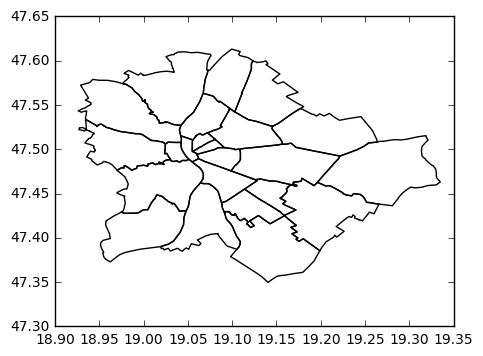

In [4]:
plot = df.plot(color='white')

## Get centroids of the districts

It is also a simple task with GeoPandas as it uses [`Shapely`](http://toblerity.org/shapely/index.html) for hangling geometries and the [`Polygon`](http://toblerity.org/shapely/manual.html#polygons) objects have a `centroid` method that gives back a [`Point`](http://toblerity.org/shapely/manual.html#points) object.

It can be used for the whole `geometry` column in the [`GeoDataFrame`](http://geopandas.org/data_structures.html#geodataframe), that stores geometry as a [`GeoSeries`](http://geopandas.org/data_structures.html#geoseries). I store the centroids in a new column called `centroid`.

Now it just has to be plotted to the same figure as the districts. For this, I used the [`scatter`](http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.scatter) function of [Matplotlib](http://matplotlib.org/index.html). This needs two vector of ordinates. Instead of this, I have a vector od Points, containing the two ordinates. To solve this problem I used a lambda expression found here: https://github.com/geopandas/geopandas/issues/246. With this I could extract the ordinates as vectors.

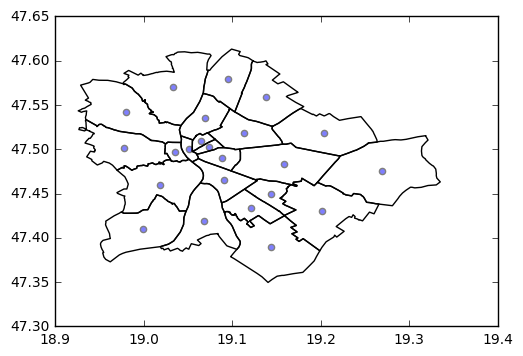

In [5]:
centroid_plot = df.plot(color='white')
df["centroid"] = df["geometry"].centroid

# print(df["centroid"].apply(lambda p: p.y))
centroid_plot.scatter(df["centroid"].apply(lambda p: p.x), df["centroid"].apply(lambda p: p.y))

## Count points over polygons

First generate some (random) test data into the `points` array. For a floating point ranged random ceneration the [`random.uniform`](https://docs.python.org/3/library/random.html#random.uniform) method can be used. For the bounds I used a louse surrounding square of Budapest and generated 500 points like this. Now, I stored the coordinates in tuples, so I also needed a trick to plot them with the `scatter` method. This time I got help from here: http://stackoverflow.com/a/17478866/4737417.

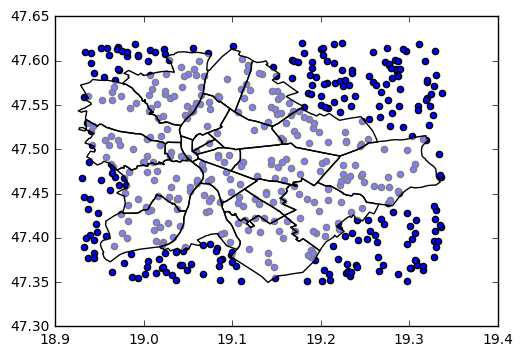

In [6]:
import random

points = []
for i in range(500):
    points.append((random.uniform(18.93,19.3375),random.uniform(47.35,47.62)))

plot = df.plot(color='white')
# with some help from http://stackoverflow.com/a/17478866/4737417
plot.scatter(*zip(*points))

The next step is counting the points by the districts. If a point is outside any of the districts the left 'uncounted'.

How to determine whether a point is over a district (polygon)? The Shapely package has an easy solution for this: the [`intersects`](http://toblerity.org/shapely/shapely.geometry.html#shapely.geometry.base.BaseGeometry.intersects) method.

A simple example to test it to create some points (`p1`, `p2`, `p3`) and a polygon (`poly`) then test all the three points based on this post: http://stackoverflow.com/a/30440386/4737417.

In [7]:
from shapely.geometry import *

p1 = Point(.5,.5)
p2 = Point(.5,1)
p3 = Point(1,1)

poly = Polygon([(0,0), (0,2), (2,2), (2,0)])

# with some help from http://stackoverflow.com/a/30440386/4737417
for p in [p1, p2, p3]:
    print(poly.intersects(p))    

# for i in range(23):    
#     print(df['geometry'][i].intersects(df["centroid"][i]))

True
True
True


### Count points over the districts

I do the counting "manually" in the following example. I create an empty [dictionary](https://docs.python.org/3/tutorial/datastructures.html#dictionaries) for the counting. I use district identifiers (`did`), that was added by me to the GeoJSON as keys and the values will be the counts, that are set to zero for starting. 

Iterating over the districts and the points. If a point intersects with the district (polygon) I increase the counter by one. After that the dictionary is converted to a Pandas DataFrame and "reindexed" (reseted its index).

The newly created `counts_df` DataFrame can be easily merged into the GeoDataFrame containing the district geometries by the `did` column with the `merge` method of the GeoDataFrame as shown in http://geopandas.org/mergingdata.html.
Note that, the GeoDataFrame has to be on the left and the DataFrame on the right, otherwise the resulting object will be DataFrame ainstead of GeoDataFrame!

In [8]:
import pandas as pd

counts = {}
for index, row in df.iterrows():
    counts[row.did] = 0
    for p in points:
        if row.geometry[0].intersects(Point(p)):
            if row.did in counts:
                counts[row.did] += 1
            else:
                counts[row.did] = 1
counts_df = pd.DataFrame.from_dict(counts, orient="index")

counts_df.reset_index(level=0, inplace=True)
#http://stackoverflow.com/a/11346337/4737417
counts_df.columns = ['did', 'count']

# based on http://geopandas.org/mergingdata.html
df = df.merge(counts_df, on='did')

## Choropleth

Taken from the [Wikipedia](https://en.wikipedia.org/wiki/Choropleth_map), a "choropleth map is a thematic map in which areas are shaded or patterned in proportion to the measurement of the statistical variable being displayed on the map".

Use the previously counted points per district to color the city according to the count of points (based on https://ocefpaf.github.io/python4oceanographers/blog/2015/08/24/choropleth/). The yellow-green color scheme is used in the example below and the alpha is set it 1 (default is 0.5).

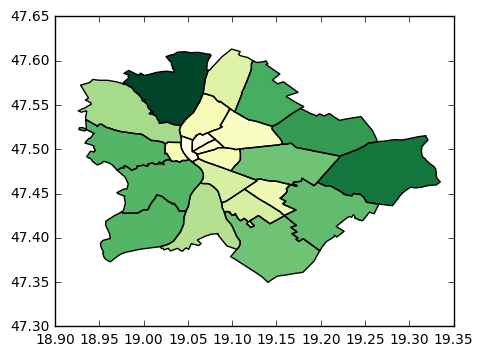

In [9]:
df.plot(column='count', cmap="YlGn", alpha=1);

## Generate grid

Next, I want to generate a 500 meters × 500 meters grid over Budapest. To generate a grid on ots own is not too complicated, but the geometry, the polygons and the points of the city is in a degree based geodetic coordinate system called World Geodetic System 1984, shortly WSG84, that is used in GPS. It is also called [EPSG:4326](https://epsg.io/4326).

In this coordinate system is not really possible to use meter as unit. Of course it can be approximated, hence 0.01 (0° 00′ 36″) is about 1.1132 km at the equator, *but* the problem is only true at the equator. Farther on it is less and less. More about this [in the Wiki](https://en.wikipedia.org/wiki/Decimal_degrees).

So, I have to reproject the original coordination system (ESPG:4326) to a proper one with metric unit. Finding the proper one is not necessarily easy. There are many topographic mappings with different scales and for different areas. E.g. for a city, for a country or for a slice of the globe. The smaller the scale of the mappings, the more precise the mapping should be. 

There is a projection containing Hungary called [EPSG:23700](http://spatialreference.org/ref/epsg/hd72-eov/), that seems to be acceptable hence Hungary is not so big. 

([EPSG:23034](http://spatialreference.org/ref/epsg/23034/) also covers the most of the country, but it is much larger and might not be so precise, even as [EPSG:4258](http://www.spatialreference.org/ref/epsg/4258/) that has a scope of Europe.)

In [10]:
#http://gis.stackexchange.com/questions/54119/creating-square-grid-polygon-shapefile-with-python
import shapefile as shp
import math

# minx,maxx,miny,maxy = xxxxx, xxxxx, xxxxx, xxxxx (specify the extents)
# dx = xx (size of grid)
# dy = xx (size of grid)
minx,maxx,miny,maxy = 18.93, 19.3375, 47.35, 47.62
dx = 1000
dy = 1000

nx = int(math.ceil(abs(maxx - minx)/dx))
ny = int(math.ceil(abs(maxy - miny)/dy))

w = shp.Writer(shp.POLYGON)
w.autoBalance = 1
w.field("ID")
id=0

for i in range(ny):
    for j in range(nx):
        id+=1
        vertices = []
        parts = []
        vertices.append([min(minx+dx*j,maxx),max(maxy-dy*i,miny)])
        vertices.append([min(minx+dx*(j+1),maxx),max(maxy-dy*i,miny)])
        vertices.append([min(minx+dx*(j+1),maxx),max(maxy- dy*(i+1),miny)])
        vertices.append([min(minx+dx*j,maxx),max(maxy-dy*(i+1),miny)])
        parts.append(vertices)
        w.poly(parts)
        w.record(id)

# w.save('polygon_grid')

### Projections in Geopandas

Managing projections in Geopandas is easy, the `to_crs` function solves this (CRS means Coordinate Reference System), read more [Managing Projections](http://geopandas.org/projections.html).

See below the EPSG:4326 and the EPSG:23700 "version" of Budapest.

{'init': 'epsg:4326'}
{'init': 'epsg:23700'}


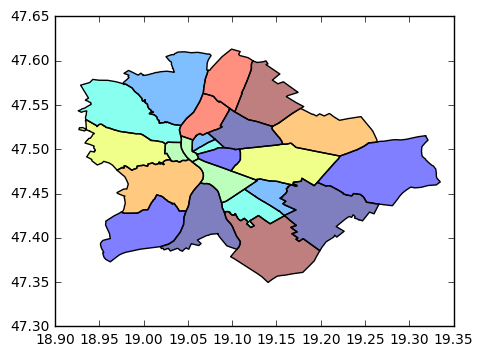

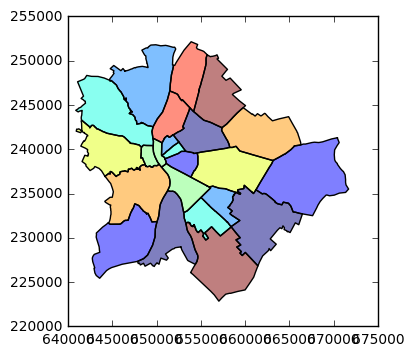

In [11]:
df.plot()
s = df.to_crs({'init': 'epsg:23700'})
print(df.crs)

print(s.crs)
s.plot()

### Bounding box

For generating the grid exactly to Budapest, the bounding box of the multipolygon has to be determined before. One of its corner can be the starting point for the grid generation. Geopandas provides many useful functions via Shapely for this purpose.

1. `boundary` to get the border of a polygon
2. `convex_hull` to get convex polygon that surround a polygony
3. `envelope` to get a bounding square of a polygon

The results of these three is plotted below in this order. It can be seen that they works on every polygon, hence I have a multipolygon. These have to be merged first to get a bounding square of the whole city. To achieve this the [`cascaded_union`](http://toblerity.org/shapely/manual.html#shapely.ops.cascaded_union) is used. It is well-explained [here](http://stackoverflow.com/a/40386377/4737417).

Now, the `envelope` function can be used on the merged polygon.

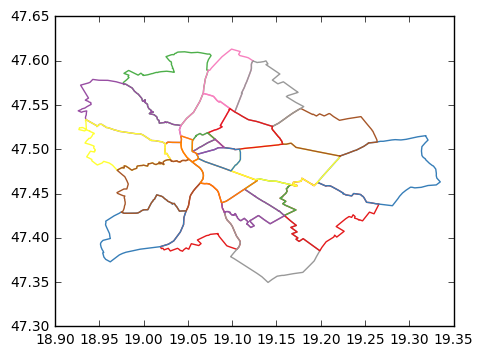

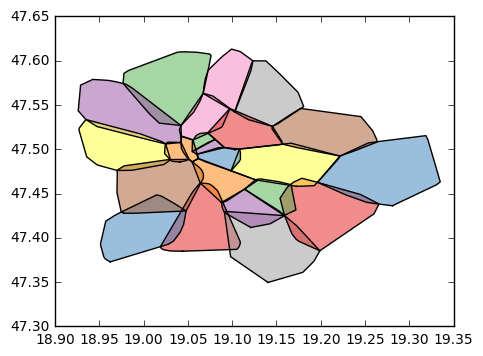

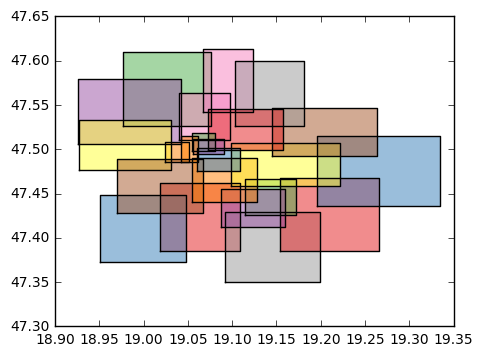

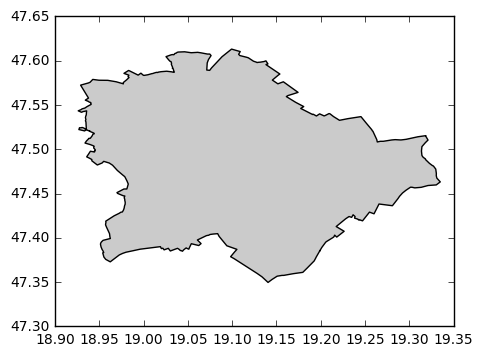

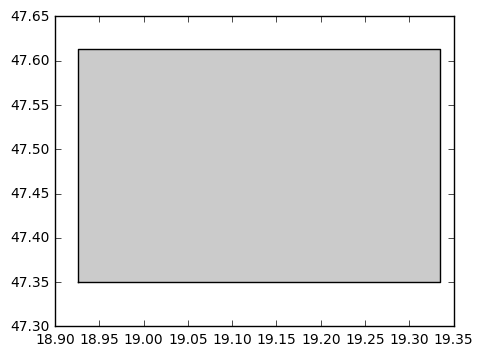

In [12]:
df.boundary.plot()
df.convex_hull.plot()
df.envelope.plot()

# based on http://stackoverflow.com/a/40386377/4737417
from shapely.ops import cascaded_union
gpd.GeoSeries(cascaded_union(df.geometry)).plot()
gpd.GeoSeries(cascaded_union(df.geometry)).envelope.plot()

### The actual grid generation

I generate the grid "manually" with two loops to calculate the points of every cell, and create a polygon of these points. The polygons are stored in an array then converted to a GeoSeries (which is returned by the function).

N.B.: The given value for the grid range still not from the formerly calculated city coundaries, and 1000 × 1000 meter grid is generated in the example below.

After the grid was generated, the initial CRS was set to ESPG:23700, hence the coordinates was taken fro that coordination system, after that it was re-projected to ESPG:4326 (WSG84).

{'init': 'epsg:23700'}
{'init': 'epsg:4326'}


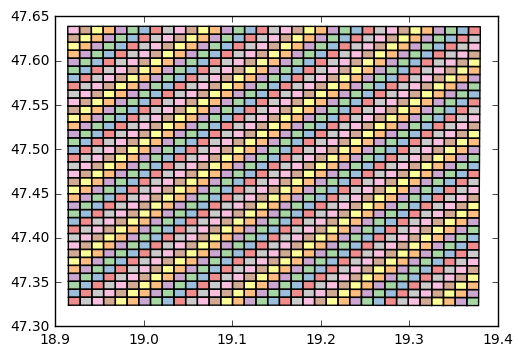

In [13]:
from geopandas import GeoSeries

def grid(minx, miny, maxx, maxy, dx, dy):
# for x, y in zip(range(minx, maxx+1, dx), range(miny, maxy+1, dy)):
    mp = []
    for x in range(minx, maxx, dx):
        for y in range(miny, maxy, dy):
            p = [(x, y),(x + dx, y), (x + dx, y + dy), (x, y + dy)]
            mp.append(Polygon(p))
    return GeoSeries(mp)

grid = grid(640000,220000,675000,255000,1000,1000)
grid.crs = {'init' :'epsg:23700'}
print(grid.crs)
grid = grid.to_crs({'init': 'epsg:4326'})
print(grid.crs)

grid.plot()

## Eliminating the unneeded cells from the grid

The grid is generated over the bounding square, so there are cells that covers place outside the city. These are not required and will be dropped. For this it has to be decide which ones are outside the city. Fortunately, this is analoguous to the point intersection.

### Polygon intersection

Here is an example for polygon intersection based on this: ttp://geopandas.org/set_operations.html. For polygon is created and only for plotting converted to GeoSeries. The results of the intersection checks are printed out. `p1` is the big polygon and its intersects with `p2` and `p4` (which half is inside, half is outside), but not intersects with `p3`. `p4` also intersects with `p3`, hence has a common point (5,2).

True
False
True
True


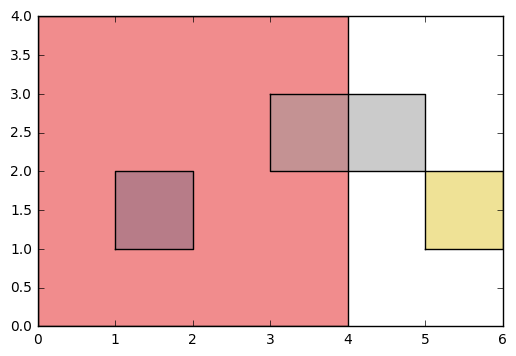

In [14]:
p1 = Polygon([(0,0), (4,0), (4,4), (0,4)])
p2 = Polygon([(1,1), (2,1), (2,2), (1,2)])
p3 = Polygon([(5,1), (6,1), (6,2), (5,2)])
p4 = Polygon([(3,3), (5,3), (5,2), (3,2)])

GeoSeries([p1,p2,p3,p4]).plot()

print(p1.intersects(p2))
print(p1.intersects(p3))
print(p1.intersects(p4))
print(p4.intersects(p3))

Droping out a polygon from a GeoSeries is simple by its index. When big polygon (`p1`) is dropped the result can be seen below.

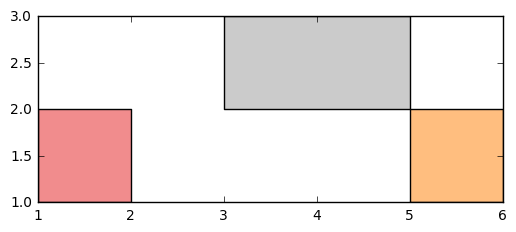

In [15]:
GeoSeries([p1,p2,p3,p4]).drop(0).plot()

The merged multipolygon of Budapest is stored in the `whole_bp` variable and used for eliminating the unrequired cells from the grid.

Iterating over `grid` (which is a GeoSeries) and check every cell whether it intersects the city (`whole_bp`). For some reason the `intersects` function gives back a Series of two object and the logical value is stored in the second one, so it is extracted by the `iloc(1)[0]` expression.

The indexes of the cells to be dropped are gatheres into an array `to_drop` and later iterating over this array and for every element a `drop` function is called for the indexes. The `inplace=True` results that the dropping operation is executed on the GeoSeries that is called upon. Note that I copied the original `grid` object to a `grid_cleared` and worked on that one.

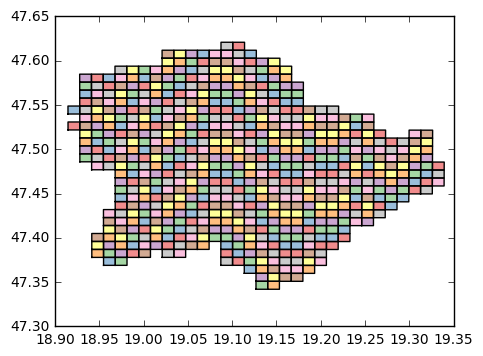

In [16]:
bp_whole = gpd.GeoSeries(cascaded_union(df.geometry))

# grid = gpd.GeoDataFrame({'geometry': g, 'df1':list(range(0,len(g)))})
# # print(grid)
# from geopandas.tools import overlay
# newdf = overlay(grid, bp_whole, how="intersection")
# newdf.plot()
# print(g)
to_drop=[]
for index,cell in grid.iteritems():
    if not bp_whole.intersects(cell).iloc(1)[0]:# for some reason it returns a series
        to_drop.append(index)

grid_cleared = grid
for i in to_drop:
    grid_cleared.drop(i, inplace=True)

grid_cleared.plot()

## Save as GeoJSON

Finally save the the grid to a GeoJSON file. As the GeoDataFrame has a `to_json` method, that returns the GeoJSON as a string, first I created a GeoDataFrame from the GeoSeries. This basically means that I put the GeoSeries into a column named `geometry`. Additionally I also added a column with an ID.

In [18]:
grid_gdf = gpd.GeoDataFrame({'geometry': grid_cleared, 'id':list(range(0,len(grid_cleared)))})

with open("output/my_own_grid_1000.geo.json", "w") as file:
    print(grid_gdf.to_json(), file=file)

## Some link that not listed as source, but potentially can be useful

* [GIS in Python](http://www.data-analysis-in-python.org/t_gis.html)
* [Python GIS Resources - packages](https://pythongisresources.wordpress.com/packages/)
* http://geojson.io
* [GeoJSON validator](http://geojsonlint.com/)

* [Python GDAL/ODR examples](https://pcjericks.github.io/py-gdalogr-cookbook/vector_layers.html)
* [Plotting data on a map (Example Gallery)](http://matplotlib.org/basemap/users/examples.html)
* https://github.com/mlaloux/My-Python-GIS_StackExchange-answers/blob/master/Generate%20grid%20programmatically%20using%20QGIS%20from%20Python.md
    * `processing` package is necessary for this, but for some reason it have not isntalled wit pip
    * can create hexagonal grid as well
* Post about working with GeoPandas
    * https://borealperspectives.wordpress.com/2016/03/07/plotting-polygon-shapefiles-on-a-matplotlib-basemap-with-geopandas-shapely-and-descartes/
        * very nice map plotting
    * [GeoPandas - the perfect marriage between shapefiles and dataframes](https://gist.github.com/jorisvandenbossche/7b30ed43366a85af8626)
    * [Geocomputation, Cartography, and Spatial Analysis Techniques Using Python](https://github.com/urschrei/Geopython/blob/master/README.md)
    * [Blogpost "Geodata manipulation with GeoPandas" by Michelle Fullwood](https://michelleful.github.io/code-blog/2015/04/29/geopandas-manipulation/)

* [Karta - Python toolkit for geospatial analysis](https://karta.fortyninemaps.com/)
* [geopandas and mpleaflet](http://lenguyenthedat.com/drawing-maps-python/)
* [OpenStreetMap city blocks as GeoJSON polygons](https://peteris.rocks/blog/openstreetmap-city-blocks-as-geojson-polygons/)
* [Creating Map Visualizations in \<10 lines of Python](http://wrobstory.github.io/2013/04/python-maps-choropleth.html)
  
* [Create own CRS with QGIS](http://gis.stackexchange.com/questions/87152/how-to-reproject-wgs84-to-a-metric-coordinate-system-with-own-reference-point-in)
* [On the fly re-project in QGIS](http://gis.stackexchange.com/a/114577)
* [Transformation between Hungarian EOV and ETRS89 based on proj4 grids](https://github.com/OSGeoLabBp/eov2etrs/)

* [Mathematical summary about tessellations](http://mathstat.slu.edu/escher/index.php/Tessellations_by_Squares,_Rectangles_and_other_Polygons)

* [Tesselations with spatialite](https://www.gaia-gis.it/fossil/libspatialite/wiki?name=tesselations-4.0)

* GIS reated Python packages
    * https://pypi.python.org/pypi/descartes/0.1
    * https://pypi.python.org/pypi/pyproj
    * https://pypi.python.org/pypi/spacegrids/
    * https://pypi.python.org/pypi/geopy/1.11.0
    * https://pypi.python.org/pypi/Gryd/1.1.0
* [Geographic Data Science - online stuff, slides and more](http://darribas.org/gds15/)



### More links without categorization - TODO

* http://gis.stackexchange.com/questions/97462/creating-grid-polygons-from-coordinates-using-r-or-python
* https://grass.osgeo.org/grass70/manuals/v.mkgrid.html

https://github.com/GeospatialPython/pyshp

http://kiwi.atmos.colostate.edu/BUGS/geodesic/interpolate.html
http://scitools.org.uk/cartopy/docs/v0.13/matplotlib/gridliner.html
http://scitools.org.uk/cartopy/docs/v0.13/matplotlib/advanced_plotting.html
https://ocefpaf.github.io/python4oceanographers/blog/2015/02/02/cartopy_folium_shapefile/

http://stackoverflow.com/questions/36231289/sum-the-total-line-length-inside-grid-using-python
http://gis.stackexchange.com/questions/139739/how-to-merge-polygons-using-geodataframe


http://stackoverflow.com/questions/39630501/spatial-index-to-find-points-within-polygon-if-points-and-polygon-have-same-min

rasterio/pyshp
http://gis.stackexchange.com/questions/209785/creating-numpy-array-with-grid-cell-area-in-gdal-rasterio/209942
http://gis.stackexchange.com/questions/54119/creating-square-grid-polygon-shapefile-with-python
https://github.com/GeospatialPython/pyshp


.loadshp bp districts CP1252 23032
23034 budapest http://spatialreference.org/ref/epsg/23034/
SELECT asgeojson (ST_SquareGrid(geometry, 1000)) FROM budapest;
http://morphocode.com/using-ogr2ogr-convert-data-formats-geojson-postgis-esri-geodatabase-shapefiles/

ST_Transform( geom Geometry , newSRID Integer ) : Geometry
http://stackoverflow.com/a/12205530/4737417 projekció átváltásról és távolságszámításról